In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray
import rasterio
import matplotlib.pyplot as plt
import pyproj
import warnings
import os

from functools import partial
from shapely.ops import transform,cascaded_union
from keplergl import KeplerGl
from shapely.geometry import mapping
from shapely.wkt import loads
from rasterio import plot

import sys
sys.path.insert(1, '../config/')
import kepler_configs

import pycrs


%matplotlib inline
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False
pd.options.display.max_columns = None

In [2]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [3]:
def flip(x, y):
    """Flips the x and y coordinate values"""
    return y, x

# LAHORE

In [4]:
lahore_grid = gpd.read_file('../data/vector/dev/LAHORE/lahore_voronoi_fishnet_1000m.shp')
district_shp_path  = '../data/vector/pak_administrative_shapefiles/District_Boundary.shp'
districts_gpd = gpd.read_file(district_shp_path)


In [5]:
## tiff selector
district_name = 'LAHORE' # add district name here
select_df = pd.DataFrame(set(districts_gpd[districts_gpd.DISTRICT.isin([district_name])].geometry.values[0].exterior.coords))
select_df = select_df.rename(columns={0:'lon',1:'lat'})
lat_min,lat_max,lon_min,lon_max = select_df.lat.min(),select_df.lat.max(),select_df.lon.min(),select_df.lon.max()

lat_lon = []
if((lat_max-lat_min)<1):
    lat_range = int((lat_max)/10)*10
    lat_lon.append(lat_range)
if((lon_max-lon_min)<1):
    lon_range = int((lon_max)/10)*10
    lat_lon.append(lon_range)

In [6]:

tiff_path_general = {'url':'../data/raster/fb_raw/population_ind_pak_general/population_ind_pak_general/population_{lat}_lon_{lon}_general-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                     'type':'general'}
tiff_path_women = {'url':'../data/raster/fb_raw/population_ind_pak_women/population_{lat}_lon_{lon}_women-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                   'type':'women'}
tiff_path_youth = {'url':'../data/raster/fb_raw/population_ind_pak_youth_15_24/population_{lat}_lon_{lon}_youth_15_24-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                   'type':'youth'}
tiff_path_reproductive = {'url':'../data/raster/fb_raw/population_ind_pak_women_of_reproductive_age_15_49/population_{lat}_lon_{lon}_women_of_reproductive_age_15_49-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                          'type':'reproductive'}
tiff_path_elderly = {'url':'../data/raster/fb_raw/population_ind_pak_elderly_60_plus/population_{lat}_lon_{lon}_elderly_60_plus-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                     'type':'elderly'}

tiff_list = [tiff_path_general,tiff_path_women,tiff_path_youth,tiff_path_reproductive,tiff_path_elderly]

In [7]:
for tiff in tiff_list[4:5]:
    path = tiff['url']
    print(path)
    type_ = tiff['type']
    out_tiff = '../data/dev/masked.tiff'

    req_rasterio = rasterio.open(path)
    coords = getFeatures(districts_gpd[districts_gpd.DISTRICT.isin([district_name])])
    out_img, out_transform = rasterio.mask.mask(dataset=req_rasterio, shapes=coords, crop=True)
    out_meta = req_rasterio.meta.copy()
    epsg_code = int(req_rasterio.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff","height": out_img.shape[1],"width": out_img.shape[2],
                     "transform": out_transform,"crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

    with rasterio.open(out_tiff, "w", **out_meta) as dest:
        dest.write(out_img)
        dest.close()
        
    print('read masked')
        
    lahore_pop_temp = rasterio.open(out_tiff)
    lahore_pop = rioxarray.open_rasterio(lahore_pop_temp)
    lahore_pop = lahore_pop.fillna(0)
    grid_stats = []
    
    for ind,row in lahore_grid.iterrows():
        poly = row.geometry
        poly = transform(flip, poly)
        geom = mapping(loads(str(poly)))
        grid_pop = lahore_pop.rio.clip([geom],'EPSG:4326',drop=True)
        sum_pop = grid_pop.sum().values.item()
        mean_pop = grid_pop.mean().values.item()
        max_pop = grid_pop.max().values.item()
        min_pop = grid_pop.min().values.item()
        std_pop = grid_pop.std().values.item()


        val_dict = {
        'vor_id':row.vor_id,
        'sum_pop_{TYPE}'.format(TYPE=type_):sum_pop,
        'mean_pop_{TYPE}'.format(TYPE=type_):mean_pop,
        'max_pop_{TYPE}'.format(TYPE=type_):max_pop,
        'min_pop_{TYPE}'.format(TYPE=type_):min_pop,
        'std_pop_{TYPE}'.format(TYPE=type_):std_pop
        }
        grid_stats.append(val_dict)
        
    print('aggregates done') 
    
    grid_stats_fb = pd.DataFrame(grid_stats)
    grid_stats_fb = pd.merge(lahore_grid,grid_stats_fb)
    grid_stats_fb['geometry'] = grid_stats_fb.geometry.apply(lambda x: transform(flip,x))
    grid_stats_fb.to_csv('../data/summary-stats/lhr_pop_vor_fb_{TYPE}.csv'.format(TYPE=type_),index=False)
    grid_stats_fb_gpd = gpd.GeoDataFrame(grid_stats_fb,geometry='geometry')
    map_ = KeplerGl(height=5000)
    map_.add_data(data=grid_stats_fb_gpd,name='lahore_pop')
    #map_.save_to_html(file_name='temp.html',config=kepler_configs.lahore_pop_grid)
    map_.save_to_html(file_name='../viz/lahore_pop_grid_{TYPE}_fb.html'.format(TYPE=type_),config=kepler_configs.lahore_pop_grid,read_only=False)
    
    del req_rasterio
    del coords
    del out_img
    del out_meta
    del out_transform
    del lahore_pop
    del lahore_pop_temp
    del grid_pop
    del grid_stats
    del grid_stats_fb
    del grid_stats_fb_gpd
    
    print('saved')

../data/raster/fb_raw/population_ind_pak_elderly_60_plus/population_30_lon_70_elderly_60_plus-v1.5.tif
read masked
aggregates done
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to ../viz/lahore_pop_grid_elderly_fb.html!
saved


In [10]:
# combine data in one file

import os
from functools import reduce

fb_stats = os.listdir('../data/summary-stats/')
fb_stats = [fb for fb in fb_stats if 'lhr_pop_vor_' in fb]
fb_stats = [fb for fb in fb_stats if 'combined' not in fb]
fb_stats = ['../data/summary-stats/'+fb for fb in fb_stats]
fb_stats = [pd.read_csv(fb) for fb in fb_stats]
#fb_stats[5] = fb_stats[5].drop(columns=['Unnamed: 0'])
fb_stats = [fb.drop(columns=['area_sq','area_sqrt','geometry']) for fb in fb_stats]

fb_stats_combined = df = reduce(lambda df1,df2: pd.merge(df1,df2,on='vor_id'), fb_stats)
fb_stats_combined = fb_stats_combined.fillna(0)
fb_stats_combined.to_csv('../data/summary-stats/lhr_pop_vor_fb_combined.csv',index=False)

## creating shapefile of fb parsed

In [11]:
import os
from functools import reduce

fb_stats = os.listdir('../data/summary-stats/')
fb_stats = [fb for fb in fb_stats if 'fb' in fb]
fb_stats = ['../data/summary-stats/'+fb for fb in fb_stats]
fb_stats = [pd.read_csv(fb) for fb in fb_stats]
fb_stats = [fb.drop(columns=['Unnamed: 0','area_sq','area_sqrt','geometry']) for fb in fb_stats]

KeyError: "['Unnamed: 0' 'area_sq' 'area_sqrt' 'geometry'] not found in axis"

KeyError: "['Unnamed: 0' 'area_sq' 'area_sqrt' 'geometry'] not found in axis"

In [24]:
fb_stats_combined = df = reduce(lambda df1,df2: pd.merge(df1,df2,on='vor_id'), fb_stats)

In [ ]:
fb_stats_combined.to_csv('../data/summary-stats/lhr_pop_vor_fb_combined.csv',index=False)

## convert to shapefiles and plot on kepler

In [4]:
fb_stats_combined = pd.read_csv('../data/summary-stats/lhr_pop_vor_fb_combined.csv')

In [5]:
lhr_grid_gpd = gpd.read_file('../data/vector/dev/LAHORE/lahore_voronoi_fishnet_1000m.shp')

In [6]:
fb_stats_combined_gpd = pd.merge(fb_stats_combined,lhr_grid_gpd)

In [7]:
fb_stats_combined_gpd['geometry'] = fb_stats_combined_gpd.geometry.apply(lambda poly: transform(flip, poly))

In [8]:
fb_stats_combined_gpd = gpd.GeoDataFrame(fb_stats_combined_gpd,geometry='geometry')

In [9]:
map_ = KeplerGl(height=500000)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [10]:
map_.add_data(data=fb_stats_combined_gpd,name='fb_stats')

In [11]:
map_.save_to_html(file_name='../viz/lahore_fb_compare.html',config=kepler_configs.lahore_fb_data_compare,read_only=False)

Map saved to ../viz/lahore_fb_compare.html!


In [18]:
fb_stats_combined_gpd['pct_pop_youth'] = fb_stats_combined_gpd.sum_pop_youth/fb_stats_combined_gpd.sum_pop_general
fb_stats_combined_gpd['pct_pop_reproductive'] = fb_stats_combined_gpd.sum_pop_reproductive/fb_stats_combined_gpd.sum_pop_general
fb_stats_combined_gpd['pct_pop_elderly'] = fb_stats_combined_gpd.sum_pop_elderly/fb_stats_combined_gpd.sum_pop_general
fb_stats_combined_gpd['pct_pop_women'] = fb_stats_combined_gpd.sum_pop_women/fb_stats_combined_gpd.sum_pop_general

In [24]:
fb_stats_combined_gpd.to_pickle('../data/vector/dev/LAHORE/lahore_fb_stats_vor.pkl')

## test merging all rasterio images

In [3]:
# import os
# from rasterio import merge
# from rasterio.plot import show

In [4]:
# pop_list = os.listdir('../data/raster/fb_raw/population_ind_pak_general/population_ind_pak_general/')
# pop_list = [pop for pop in pop_list if 'tif' in pop]
# pop_list = ['../data/raster/fb_raw/population_ind_pak_general/population_ind_pak_general/'+pop for pop in pop_list]

In [5]:
# src_files = []
# for pop in pop_list:
#     src = rasterio.open(pop)
#     src_files.append(src)
# src_files

In [2]:
# mosaic, out_trans = merge.merge([src_files[0],src_files[7]])

# ISLAMABD

In [4]:
islamabad_grid = gpd.read_file('../data/vector/dev/ISLAMABAD/islamabad_voronoi_fishnet.shp')
district_shp_path  = '../data/vector/pak_administrative_shapefiles/District_Boundary.shp'
districts_gpd = gpd.read_file(district_shp_path)

In [5]:
## tiff selector
district_name = 'ISLAMABAD' # add district name here
select_df = pd.DataFrame(set(districts_gpd[districts_gpd.DISTRICT.isin([district_name])].geometry.values[0].exterior.coords))
select_df = select_df.rename(columns={0:'lon',1:'lat'})
lat_min,lat_max,lon_min,lon_max = select_df.lat.min(),select_df.lat.max(),select_df.lon.min(),select_df.lon.max()

lat_lon = []
if((lat_max-lat_min)<1):
    lat_range = int((lat_max)/10)*10
    lat_lon.append(lat_range)
if((lon_max-lon_min)<1):
    lon_range = int((lon_max)/10)*10
    lat_lon.append(lon_range)

In [6]:

tiff_path_general = {'url':'../data/raster/fb_raw/population_ind_pak_general/population_ind_pak_general/population_{lat}_lon_{lon}_general-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                     'type':'general'}
tiff_path_women = {'url':'../data/raster/fb_raw/population_ind_pak_women/population_{lat}_lon_{lon}_women-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                   'type':'women'}
tiff_path_youth = {'url':'../data/raster/fb_raw/population_ind_pak_youth_15_24/population_{lat}_lon_{lon}_youth_15_24-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                   'type':'youth'}
tiff_path_reproductive = {'url':'../data/raster/fb_raw/population_ind_pak_women_of_reproductive_age_15_49/population_{lat}_lon_{lon}_women_of_reproductive_age_15_49-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                          'type':'reproductive'}
tiff_path_elderly = {'url':'../data/raster/fb_raw/population_ind_pak_elderly_60_plus/population_{lat}_lon_{lon}_elderly_60_plus-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                     'type':'elderly'}


In [7]:
tiff_list = [tiff_path_general,tiff_path_women,tiff_path_youth,tiff_path_reproductive,tiff_path_elderly]

In [8]:
for tiff in tiff_list[4:5]:
    path = tiff['url']
    print(path)
    type_ = tiff['type']
    out_tiff = '../data/dev/masked.tiff'

    req_rasterio = rasterio.open(path)
    coords = getFeatures(districts_gpd[districts_gpd.DISTRICT.isin([district_name])])
    out_img, out_transform = rasterio.mask.mask(dataset=req_rasterio, shapes=coords, crop=True)
    out_meta = req_rasterio.meta.copy()
    epsg_code = int(req_rasterio.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff","height": out_img.shape[1],"width": out_img.shape[2],
                     "transform": out_transform,"crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

    with rasterio.open(out_tiff, "w", **out_meta) as dest:
        dest.write(out_img)
        
    print('read masked')
        
    pop_temp = rasterio.open(out_tiff)
    pop = rioxarray.open_rasterio(pop_temp)
    pop = pop.fillna(0)
    grid_stats = []
    
    for ind,row in islamabad_grid.iterrows():
        poly = row.geometry
        poly = transform(flip, poly)
        geom = mapping(loads(str(poly)))
        grid_pop = pop.rio.clip([geom],'EPSG:4326',drop=True)
        sum_pop = grid_pop.sum().values.item()
        mean_pop = grid_pop.mean().values.item()
        max_pop = grid_pop.max().values.item()
        min_pop = grid_pop.min().values.item()
        std_pop = grid_pop.std().values.item()


        val_dict = {
        'vor_id':row.vor_id,
        'sum_pop_{TYPE}'.format(TYPE=type_):sum_pop,
        'mean_pop_{TYPE}'.format(TYPE=type_):mean_pop,
        'max_pop_{TYPE}'.format(TYPE=type_):max_pop,
        'min_pop_{TYPE}'.format(TYPE=type_):min_pop,
        'std_pop_{TYPE}'.format(TYPE=type_):std_pop
        }
        grid_stats.append(val_dict)
        
    print('aggregates done') 
    
    grid_stats_fb = pd.DataFrame(grid_stats)
    grid_stats_fb = pd.merge(islamabad_grid,grid_stats_fb)
    grid_stats_fb['geometry'] = grid_stats_fb.geometry.apply(lambda x: transform(flip,x))
    grid_stats_fb.to_csv('../data/summary-stats/isb_pop_vor_fb_{TYPE}.csv'.format(TYPE=type_),index=False)
    grid_stats_fb_gpd = gpd.GeoDataFrame(grid_stats_fb,geometry='geometry')
    map_ = KeplerGl(height=5000)
    map_.add_data(data=grid_stats_fb_gpd,name='isb_pop')
    #map_.save_to_html(file_name='temp.html',config=kepler_configs.lahore_pop_grid)
    map_.save_to_html(file_name='../viz/islamabad_pop_grid_{TYPE}_fb.html'.format(TYPE=type_),config=kepler_configs.lahore_pop_grid,read_only=False)
    
    del req_rasterio
    del coords
    del out_img
    del out_meta
    del out_transform
    del pop
    del pop_temp
    del grid_pop
    del grid_stats
    del grid_stats_fb
    del grid_stats_fb_gpd
    
    print('saved')

../data/raster/fb_raw/population_ind_pak_elderly_60_plus/population_30_lon_70_elderly_60_plus-v1.5.tif
read masked
aggregates done
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to ../viz/islamabad_pop_grid_elderly_fb.html!
saved


In [9]:
# combine data in one file

import os
from functools import reduce

fb_stats = os.listdir('../data/summary-stats/')
fb_stats = [fb for fb in fb_stats if 'isb_pop_vor_fb' in fb]
fb_stats = [fb for fb in fb_stats if 'combined' not in fb]
fb_stats = ['../data/summary-stats/'+fb for fb in fb_stats]
fb_stats = [pd.read_csv(fb) for fb in fb_stats]
fb_stats = [fb.drop(columns=['area_sq','area_sqrt','geometry']) for fb in fb_stats]

fb_stats_combined = df = reduce(lambda df1,df2: pd.merge(df1,df2,on='vor_id'), fb_stats)
fb_stats_combined = fb_stats_combined.fillna(0)
#fb_stats_combined.to_csv('../data/summary-stats/isb_pop_vor_fb_combined.csv',index=False)

In [12]:
fb_stats_combined.to_csv('../data/summary-stats/isb_pop_vor_fb_combined.csv',index=False)

<AxesSubplot:ylabel='Frequency'>

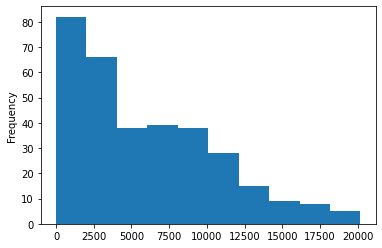

In [14]:
fb_stats_combined.sum_pop_general.plot(kind='hist')

In [30]:
fb_stats_combined_gpd = fb_stats_combined.merge(islamabad_grid)
fb_stats_combined_gpd = gpd.GeoDataFrame(fb_stats_combined_gpd,geometry='geometry')
fb_stats_combined_gpd['geometry'] = fb_stats_combined_gpd.geometry.apply(lambda x: transform(func=flip,geom=x))
map_ = KeplerGl(height=500)
map_.add_data(data=fb_stats_combined_gpd,name='fb_pop_data')

In [33]:
map_.save_to_html(file_name='../viz/islamabad_pop_grid_combined.html',config=kepler_configs.islamabad_grid_population_fb)

# KARACHI

In [4]:
karachi_grid = gpd.read_file('../data/vector/dev/KARACHI/karachi_voronoi_fishnet.shp')
district_shp_path  = '../data/vector/pak_administrative_shapefiles/District_Boundary.shp'
districts_gpd = gpd.read_file(district_shp_path)


In [5]:
#districts_gpd = gpd.read_file(district_shp_path)
karachi_districts = districts_gpd[districts_gpd.DISTRICT.isin(['KARACHI CENTRAL', 'KARACHI WEST',
       'MALIR CANTONMENT', 'KORANGI CREEK CANTONMENT',
       'MANORA CANTONMENT', 'CLIFTON CANTONMENT', 'KARACHI CANTONMENT',
       'FAISAL CANTONMENT', 'KARACHI SOUTH', 'MALIR', 'KORANGI',
       'KARACHI EAST'])]
karachi_whole_poly = cascaded_union(karachi_districts.geometry)
karachi_whole_df = pd.DataFrame(np.array([[130,'SINDH','KARACHI FULL',0,'CUSTOM',karachi_districts.Shape_Le_1.sum(),
                                          karachi_districts.Shape_Le_2.sum(),karachi_districts.Shape_Area.sum(),
                                          karachi_whole_poly]]),columns=karachi_districts.columns)
karachi_whole_gpd = gpd.GeoDataFrame(karachi_whole_df,geometry='geometry')
karachi_whole_gpd.crs = districts_gpd.crs

districts_gpd = districts_gpd.append(karachi_whole_df)

In [6]:
## tiff selector
district_name = 'KARACHI FULL' # add district name here
select_df = pd.DataFrame(set(districts_gpd[districts_gpd.DISTRICT.isin([district_name])].geometry.values[0].exterior.coords))
select_df = select_df.rename(columns={0:'lon',1:'lat'})
lat_min,lat_max,lon_min,lon_max = select_df.lat.min(),select_df.lat.max(),select_df.lon.min(),select_df.lon.max()

lat_lon = []
if((lat_max-lat_min)<1):
    lat_range = int((lat_max)/10)*10
    lat_lon.append(lat_range)
if((lon_max-lon_min)<1):
    lon_range = int((lon_max)/10)*10
    lat_lon.append(lon_range)

In [7]:

tiff_path_general = {'url':'../data/raster/fb_raw/population_ind_pak_general/population_ind_pak_general/population_{lat}_lon_{lon}_general-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                     'type':'general'}
tiff_path_women = {'url':'../data/raster/fb_raw/population_ind_pak_women/population_{lat}_lon_{lon}_women-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                   'type':'women'}
tiff_path_youth = {'url':'../data/raster/fb_raw/population_ind_pak_youth_15_24/population_{lat}_lon_{lon}_youth_15_24-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                   'type':'youth'}
tiff_path_reproductive = {'url':'../data/raster/fb_raw/population_ind_pak_women_of_reproductive_age_15_49/population_{lat}_lon_{lon}_women_of_reproductive_age_15_49-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                          'type':'reproductive'}
tiff_path_elderly = {'url':'../data/raster/fb_raw/population_ind_pak_elderly_60_plus/population_{lat}_lon_{lon}_elderly_60_plus-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                     'type':'elderly'}

tiff_list = [tiff_path_general,tiff_path_women,tiff_path_youth,tiff_path_reproductive,tiff_path_elderly]

In [8]:
for tiff in tiff_list[4:5]:
    path = tiff['url']
    print(path)
    type_ = tiff['type']
    out_tiff = '../data/dev/masked.tiff'

    req_rasterio = rasterio.open(path)
    coords = getFeatures(districts_gpd[districts_gpd.DISTRICT.isin([district_name])])
    out_img, out_transform = rasterio.mask.mask(dataset=req_rasterio, shapes=coords, crop=True)
    out_meta = req_rasterio.meta.copy()
    epsg_code = int(req_rasterio.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff","height": out_img.shape[1],"width": out_img.shape[2],
                     "transform": out_transform,"crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

    with rasterio.open(out_tiff, "w", **out_meta) as dest:
        dest.write(out_img)
        
    print('read masked')
        
    pop_temp = rasterio.open(out_tiff)
    pop = rioxarray.open_rasterio(pop_temp)
    pop = pop.fillna(0)
    grid_stats = []
    
    for ind,row in karachi_grid.iterrows():
        poly = row.geometry
        poly = transform(flip, poly)
        geom = mapping(loads(str(poly)))
        grid_pop = pop.rio.clip([geom],'EPSG:4326',drop=True)
        sum_pop = grid_pop.sum().values.item()
        mean_pop = grid_pop.mean().values.item()
        max_pop = grid_pop.max().values.item()
        min_pop = grid_pop.min().values.item()
        std_pop = grid_pop.std().values.item()


        val_dict = {
        'vor_id':row.vor_id,
        'sum_pop_{TYPE}'.format(TYPE=type_):sum_pop,
        'mean_pop_{TYPE}'.format(TYPE=type_):mean_pop,
        'max_pop_{TYPE}'.format(TYPE=type_):max_pop,
        'min_pop_{TYPE}'.format(TYPE=type_):min_pop,
        'std_pop_{TYPE}'.format(TYPE=type_):std_pop
        }
        grid_stats.append(val_dict)
        
    print('aggregates done') 
    
    grid_stats_fb = pd.DataFrame(grid_stats)
    grid_stats_fb = pd.merge(karachi_grid,grid_stats_fb)
    grid_stats_fb['geometry'] = grid_stats_fb.geometry.apply(lambda x: transform(flip,x))
    grid_stats_fb.to_csv('../data/summary-stats/khi_pop_vor_fb_{TYPE}.csv'.format(TYPE=type_),index=False)
    grid_stats_fb_gpd = gpd.GeoDataFrame(grid_stats_fb,geometry='geometry')
    map_ = KeplerGl(height=5000)
    map_.add_data(data=grid_stats_fb_gpd,name='khi_pop')
    #map_.save_to_html(file_name='temp.html',config=kepler_configs.lahore_pop_grid)
#     map_.save_to_html(file_name='../viz/karachi_pop_grid_{TYPE}_fb.html'.format(TYPE=type_),config=kepler_configs.lahore_pop_grid,read_only=False)
    
    del req_rasterio
    del coords
    del out_img
    del out_meta
    del out_transform
    del pop
    del pop_temp
    del grid_pop
    del grid_stats
    del grid_stats_fb
    del grid_stats_fb_gpd
    
    print('saved')

../data/raster/fb_raw/population_ind_pak_elderly_60_plus/population_20_lon_60_elderly_60_plus-v1.5.tif
read masked
aggregates done
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
saved


In [14]:
# combine data in one file

import os
from functools import reduce

fb_stats = os.listdir('../data/summary-stats/')
fb_stats = [fb for fb in fb_stats if 'khi_pop' in fb]
fb_stats = [fb for fb in fb_stats if 'combined' not in fb]
fb_stats = ['../data/summary-stats/'+fb for fb in fb_stats]
fb_stats = [pd.read_csv(fb) for fb in fb_stats]
#fb_stats[5] = fb_stats[5].drop(columns=['Unnamed: 0'])
fb_stats = [fb.drop(columns=['area_sq','area_sqrt','geometry']) for fb in fb_stats]

fb_stats_combined = df = reduce(lambda df1,df2: pd.merge(df1,df2,on='vor_id'), fb_stats)
fb_stats_combined = fb_stats_combined.fillna(0)
fb_stats_combined.to_csv('../data/summary-stats/khi_pop_vor_fb_combined.csv',index=False)

In [13]:
fb_stats_combined

,vor_id,sum_pop_general,mean_pop_general,max_pop_general,min_pop_general,std_pop_general,sum_pop_elderly,mean_pop_elderly,max_pop_elderly,min_pop_elderly,std_pop_elderly,sum_pop_women,mean_pop_women,max_pop_women,min_pop_women,std_pop_women,sum_pop_youth,mean_pop_youth,max_pop_youth,min_pop_youth,std_pop_youth,sum_pop_reproductive,mean_pop_reproductive,max_pop_reproductive,min_pop_reproductive,std_pop_reproductive
0,vor0,121.646556,0.043461,30.411639,0.0,1.148835,5.718760,0.002043,1.429690,0.0,0.054008,56.278692,0.020107,14.069673,0.0,0.531498,29.220796,0.010440,7.305199,0.0,0.275962,29.309412,0.010471,7.327353,0.0,0.276799
1,vor1,3771.043236,0.821041,60.823278,0.0,5.245659,177.281560,0.038598,2.859380,0.0,0.246605,1744.639452,0.379847,28.139346,0.0,2.426857,905.844676,0.197223,14.610398,0.0,1.260063,908.591772,0.197821,14.654706,0.0,1.263884
2,vor2,1338.112116,0.369542,60.823278,0.0,3.554480,62.906360,0.017373,2.859380,0.0,0.167101,619.065612,0.170965,28.139346,0.0,1.644448,321.428756,0.088768,14.610398,0.0,0.853824,322.403532,0.089037,14.654706,0.0,0.856413
3,vor3,152.058195,0.032568,30.411639,0.0,0.994673,7.148450,0.001531,1.429690,0.0,0.046761,70.348365,0.015067,14.069673,0.0,0.460176,36.525995,0.007823,7.305199,0.0,0.238931,36.636765,0.007847,7.327353,0.0,0.239656
4,vor4,2189.638008,0.570962,60.823278,0.0,4.410162,102.937680,0.026842,2.859380,0.0,0.207327,1013.016456,0.264150,28.139346,0.0,2.040322,525.974328,0.137151,14.610398,0.0,1.059368,527.569416,0.137567,14.654706,0.0,1.062581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,vor1118,80.059968,0.017059,20.014992,0.0,0.461640,3.580928,0.000763,0.895232,0.0,0.020648,35.898720,0.007649,8.974680,0.0,0.206999,18.545048,0.003952,4.636262,0.0,0.106934,18.519424,0.003946,4.629856,0.0,0.106786
1119,vor1119,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1120,vor1120,170.127432,0.055254,20.014992,0.0,0.824627,7.609472,0.002471,0.895232,0.0,0.036884,76.284780,0.024776,8.974680,0.0,0.369761,39.408227,0.012799,4.636262,0.0,0.191016,39.353776,0.012781,4.629856,0.0,0.190752
1121,vor1121,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [15]:
fb_stats_combined_gpd = fb_stats_combined.merge(karachi_grid)
fb_stats_combined_gpd = gpd.GeoDataFrame(fb_stats_combined_gpd,geometry='geometry')
fb_stats_combined_gpd['geometry'] = fb_stats_combined_gpd.geometry.apply(lambda x: transform(func=flip,geom=x))
map_ = KeplerGl(height=500)
map_.add_data(data=fb_stats_combined_gpd,name='fb_pop_data')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [16]:
map_.save_to_html(file_name='../viz/karachi_pop_grid_combined.html',config=kepler_configs.islamabad_grid_population_fb)

Map saved to ../viz/karachi_pop_grid_combined.html!
